<h1 align="center">
        <picture>
         <source media="(prefers-color-scheme: dark)" srcset="https://user-images.githubusercontent.com/16140783/218357099-29d4848f-89ee-463e-9ead-40f27c976f61.png">
         <img width="300" src="https://user-images.githubusercontent.com/16140783/218437368-1aa8506c-1ed8-460a-99de-d2c081557170.png" align="center"></img>
    </picture><br/><br/>Subvocalization EMG - PoC<sub><sup><br/>(Subvocalization)</sup></sub>
</h1>

Project for recording and training subvocalization **EMG** data with the Cyton Board. This is the final PoC of the project containing the steps of processing and training with real subvocalization data. Developed by **Mateus de Aquino Batista** for the Bachelor's Degree Final Project.


### Packages

First, after recording the raw data with Brainflow, we can start processing the data, so let's start installing the required packages for reading the saves, preprocessing, plotting and training a new model.

In [1]:
%load_ext autoreload
%autoreload 2
    
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, NoiseTypes
from brainflow.board_shim import BoardShim, BoardIds
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import np_utils

2023-11-28 10:26:29.078160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 10:26:29.121851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 10:26:29.122766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 10:26:29.897647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reading raw EMG data

The sEMG data will be read from the Cyton Dongle through [BrainFlow](https://brainflow.readthedocs.io/en/stable/SupportedBoards.html#cyton), you can also check the [Code Samples](https://brainflow.readthedocs.io/en/stable/Examples.html) section to know how to get the data from the board and read/write it to a csv file.

In [2]:
restored_data = pd.read_csv("../dist/saves/ynb_1S.csv")

restored_data

,WORD,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8
0,sim,-44977.633056,21060.797103,24212.214257,-31111.214293,7237.338392,8332.193891,187500.0,187500.0
1,sim,-44994.933307,21047.810739,24195.584559,-31141.903239,7215.903069,8318.671086,187500.0,187500.0
2,sim,-45076.673636,20991.484343,24139.124052,-31195.346260,7174.865267,8452.625090,187500.0,187500.0
3,sim,-45059.574552,21001.721442,24152.423340,-31166.758378,7195.428872,8460.336442,187500.0,187500.0
4,sim,-44988.026618,21050.604707,24200.881922,-31117.405727,7235.974936,8348.242444,187500.0,187500.0
...,...,...,...,...,...,...,...,...,...
50088,$SILENCE,-45457.837934,20557.972259,23269.082399,-33360.023303,7893.987941,8388.095604,187500.0,187500.0
50089,$SILENCE,-45420.152893,20572.389134,23280.548844,-33367.622896,7890.165793,8304.522431,187500.0,187500.0
50090,$SILENCE,-45504.664839,20525.137547,23230.749158,-33427.927903,7856.302900,8417.555203,187500.0,187500.0
50091,$SILENCE,-45539.019470,20516.420366,23220.042672,-33414.829780,7864.505990,8497.954428,187500.0,187500.0


The Cyton board has 8 channels.  

We can check this out and plot the data for each channel directly to [Matplotlib](https://matplotlib.org/). As you could tell, these graphing tools have a way higher resolution than the one used in the frontend for debugging ([Chart.js](https://www.chartjs.org/)).

[1, 2, 3, 4, 5, 6]
['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5', 'Channel_6']

Plot channels:


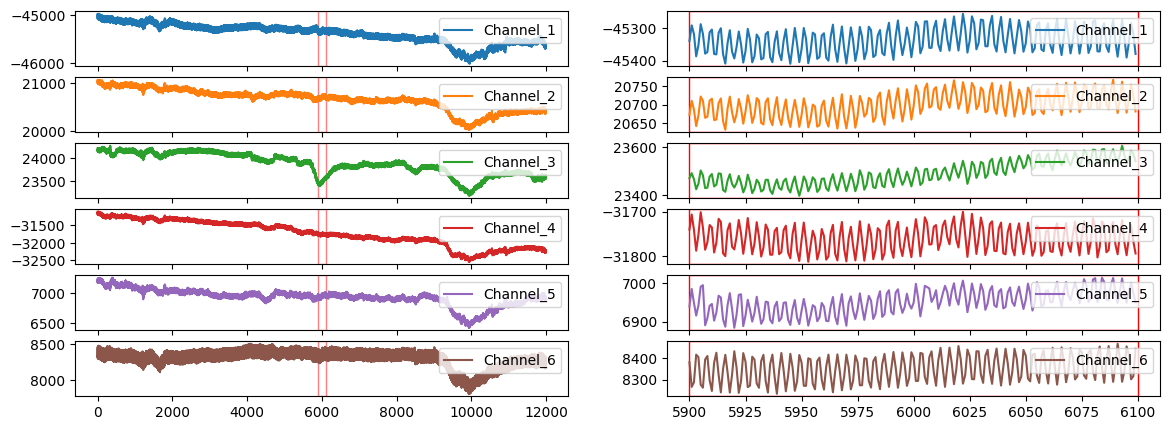

In [3]:
board_id = BoardIds.CYTON_BOARD.value
eeg_channels = [1, 2, 3, 4, 5, 6]
df_channels = list(map(lambda x: "Channel_%s" % (x), eeg_channels))
print(eeg_channels)
print(df_channels)
print("\nPlot channels:")

f, axarr = plt.subplots(6, 2, figsize=(14,5))

axs = restored_data[df_channels][:12000].plot(subplots=True, ax=axarr[:,0])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(5900, 6100, alpha=0.5, ec='red', fill=False)

axs = restored_data[df_channels][5900:6100].plot(subplots=True, ax=axarr[:,1])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(5900, 6100, alpha=1, ec='red', fill=False)

plt.show()

### Preprocessing

With our 6 channels data in hand, we can perform a Butterworth filter to select the frequency range we want to keep, here we want a lowcut of 3.0 and a highcut of 45.0:

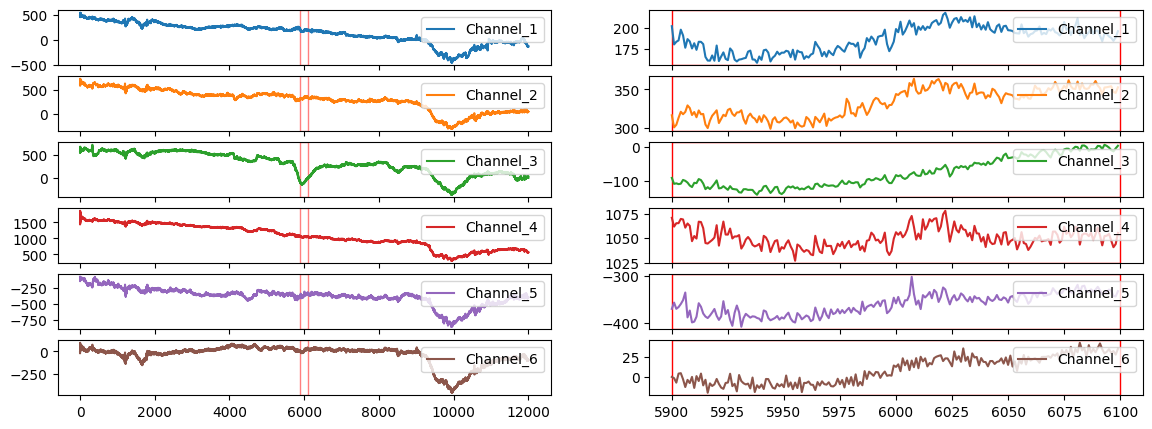

In [4]:
sampling_rate = BoardShim.get_sampling_rate(board_id)
exg_channels = BoardShim.get_exg_channels(board_id)

for count, channel in enumerate(df_channels):
    if count >= 8:
        continue
    channel_data = restored_data[channel].to_numpy()
    DataFilter.detrend(channel_data, DetrendOperations.CONSTANT.value)
    DataFilter.remove_environmental_noise(channel_data, sampling_rate, NoiseTypes.SIXTY.value);

f, axarr = plt.subplots(6, 2, figsize=(14,5))

axs = restored_data[df_channels][:12000].plot(subplots=True, ax=axarr[:,0])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(5900, 6100, alpha=0.5, ec='red', fill=False)

axs = restored_data[df_channels][5900:6100].plot(subplots=True, ax=axarr[:,1])
for i,ax in enumerate(axs):
    axs[i].legend(loc="upper right")
    axs[i].axvspan(5900, 6100, alpha=1, ec='red', fill=False)

plt.show()

### Words visualization

In this session we recorded two words "Yes" and "No" plus "Silence" with the Cyton board.
Now that we have all the session preprocessed, we need to split it in 200 samples per word, once these words are a 2d array (sample x channel) inside a list of words, all the words could be individually seen as a 2-dimensional image heatmap, knowing the columns represents each channel, and the rows are the data recorded over time:

<Figure size 640x480 with 0 Axes>

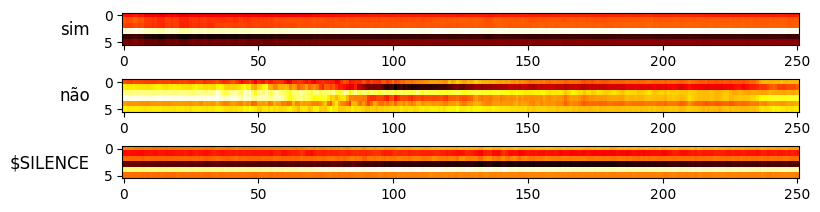

In [5]:
emg_words = []
emg_data = []

total_samples = len(restored_data['Channel_1'])
offset = 1200
samples = 251
words_to_visualize = 3

for i in range(words_to_visualize):
    sample_offset = offset + int(total_samples * (i/(words_to_visualize)))
    word = restored_data['WORD'][sample_offset]
    emg_words.append(word)
    data = restored_data[df_channels][sample_offset:(sample_offset+samples)]
    emg_data.append(data)

plt.figure()
_f, axarr = plt.subplots(len(emg_words), 1, constrained_layout=True, figsize=(10, words_to_visualize*2/3))
for i, word in enumerate(emg_words):
    axarr[i].imshow(np.transpose(emg_data[i]), cmap='hot', interpolation='none', aspect=2)
    axarr[i].set_ylabel(word, fontsize=12, y=.20, ha='right', rotation='horizontal', labelpad=10) 
plt.show()

### Training the Neural Network

We need to factorize the words array so we can get an unique list of the words used, and also retreive a list the model can read as an expected output:

In [6]:
import os
os.chdir('../')

In [7]:
from backend.training import train_network

words_map, samples, model, history = train_network(85, ["ynb_1S"], 200, 1000, 6, 200)

2023-11-28 10:26:38.095139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 10:26:38.095711: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


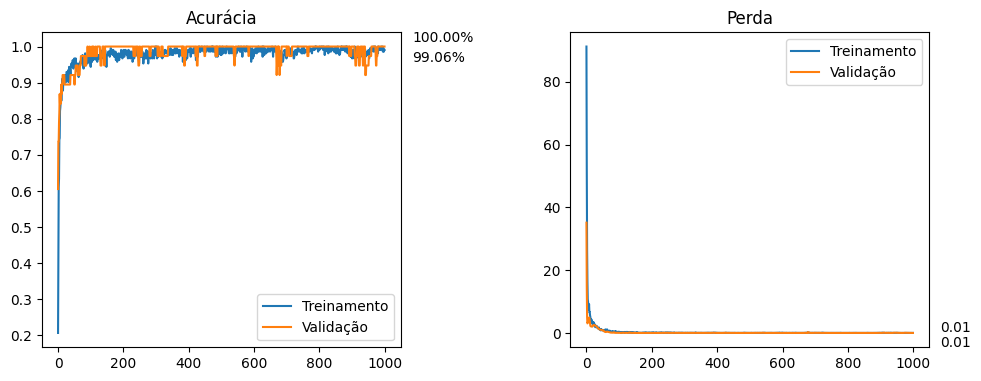

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ax1.set_title("Acurácia")
ax1.plot(accuracy, label="Treinamento")
ax1.plot(val_accuracy, label="Validação")
ax1.legend(fontsize="10")

ax2.set_title("Perda")
ax2.plot(loss, label="Treinamento")
ax2.plot(val_loss, label="Validação")
ax2.legend(fontsize="10")

i = 0
for var in (accuracy, val_accuracy):
    i+=1
    ax1.annotate('%2.2f%%' % (var[-1]*100), xy=(1, var[-1]-0.08), xytext=(8, i*12), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

for var in (loss, val_loss):
    i-=1
    ax2.annotate('%0.2f' % var[-1], xy=(1, var[-1]*60), xytext=(8, -i*12), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points')

fig.tight_layout(pad=5.0)
plt.show()